## Vision Transformer (ViT) Chest X-Ray RGB Classification Model

ไฟล์นี้เป็นโปรแกรมสำหรับฝึก Deep Learning Model (Transfer Learning) เพื่อจำแนกภาพ Chest X-Ray ระหว่าง Normal (ปกติ) และ Pneumonia (ปอดอักเสบ) โดยใช้รูปภาพ RGB ผ่านโมเดล ViT-B/16

### ขั้นตอนหลัก:
1. **Import Libraries** - นำเข้าไลบรารี่ที่จำเป็น 
2. **Load และ Prepare Data** - อ่านข้อมูลจากไฟล์และแบ่งเป็น Train/Validation/Test (4084/870/870)
3. **สร้าง Transform** - เตรียมการแปลงรูปภาพ (ขนาด 224×224, Augmentation สำหรับ training)
4. **สร้าง Dataset และ DataLoader** - สร้าง class สำหรับอ่านข้อมูล และปรับสมดุลคลาส

In [24]:
import os
import zipfile
import pandas as pd

import torch
from torch.utils.data import Dataset , DataLoader
from torchvision import transforms
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import recall_score
import torch.optim as optim
import torchvision.models as models

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import imagehash
from PIL import Image
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

## Preparation

เรียกใช้ฟังก์ชัน run_cleaning จากไฟล์ clean.py
- จัดการรูปภาพซ้ำด้วย Perceptual Hash (pHash Function)
- การแปลงภาพจากต้นฉบับเป็น RGB เพื่อรองรับ 3 channels และตรงตามรูปแบบโมเดล ResNet50
- Feature Engineering ผ่านการทำ CLAHE
    - ปรับ Contrast ตาม Histogram Equalization แบบปรับตามพื้นที่ (Adaptive HE)

In [25]:
from clean import run_cleaning
df_train_new, df_val_new, df_test_new = run_cleaning()
df_train_new.head()

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ 🚀 START CLEANING PIPELINE                                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ STEP 0 — Load DataFrame                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[INFO] Total files loaded: 5856

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ TRAIN — SKIPPED (Cache Found)                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[INFO] Using cached PHASH: Data/cache/clean_phash_train.csv

[INFO] Images: 5190

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ VAL — SKIPPED (Cache Found)                                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[INFO] Using cached PHASH: Data/cache/clean_phash_val.csv

[INFO] Images: 16

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ TEST — SKIPPED (Cache Found)                                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[INFO] Using cached PHASH: Data/cache/clean_phash_test.csv

[INFO] Images: 618

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ TRAIN — SKIPPED (RGB Cache Found)                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[INFO] Using RGB cache: Data/cache/clean_rgb_train.csv

[INFO] Images (RGB): 5190

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ VAL — SKIPPED (RGB Cache Found)                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[INFO] Using RGB cache: Data/cache/clean_rgb_val.csv

[INFO] Images (RGB): 16

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ TEST — SKIPPED (RGB Cache Found)                                                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[INFO] Using RGB cache: Data/cache/clean_rgb_test.csv

[INFO] Images (RGB): 618

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ TRAIN — SKIPPED (CLAHE Cache Found)                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[INFO] Using CLAHE cache: Data/cache/clean_clahe_train.csv

[INFO] Images (CLAHE): 5190

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ VAL — SKIPPED (CLAHE Cache Found)                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[INFO] Using CLAHE cache: Data/cache/clean_clahe_val.csv

[INFO] Images (CLAHE): 16

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ TEST — SKIPPED (CLAHE Cache Found)                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[INFO] Using CLAHE cache: Data/cache/clean_clahe_test.csv

[INFO] Images (CLAHE): 618

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ 🎉 CLEANING COMPLETE                                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[INFO] Train images: 5190

[INFO] Val images:   16

[INFO] Test images:  618

,filepath,label
0,Data/chest_xray\train\NORMAL\IM-0115-0001.jpeg,0
1,Data/chest_xray\train\NORMAL\IM-0117-0001.jpeg,0
2,Data/chest_xray\train\NORMAL\IM-0119-0001.jpeg,0
3,Data/chest_xray\train\NORMAL\IM-0122-0001.jpeg,0
4,Data/chest_xray\train\NORMAL\IM-0125-0001.jpeg,0


แบ่งชุดการเทรน (Train, Test, Validation set) สำหรับการเรียนรู้โมเดล
- All Dataset: 5,824
    - Training Set: 4,084
    - Validation Set: 870
    - Test Set: 870

In [26]:
from data_split import perform_split

df_train_final, df_val_final, df_test_final = perform_split(
    df_train_new,
    df_val_new,
    df_test_new,
    target_val=870,
    target_test=870
)
df_train_new = df_train_final.copy()
df_test_new = df_test_final.copy()
df_val_new = df_val_final.copy()


STEP: Data Split

[INFO] Remaining train images: 5190

[INFO] Need more = 1106 (val 854, test 252)

     SUMMARY     
                 
  Set     Count  
 ─────────────── 
  Train    4084  
  Val       870  
  Test      870  
  Total    5824 

CHECK OVERLAP

✔ No overlaps detected.

In [27]:
df_test_new['label'].value_counts()

label
1    569
0    301
Name: count, dtype: int64

## Transform pytorch

## การสร้าง Transform และ Dataset สำหรับข้อมูล RGB

ในส่วนนี้จะทำการ:

1. **สร้าง Transform สำหรับ RGB** (ขนาด 224×224)
   - `train_transform_rgb_aug` - สำหรับข้อมูล training พร้อมการ Augmentation (พลิก หมุน ย้าย)
   - `train_transform_rgb_noaug` - สำหรับข้อมูล training (ไม่มี Augmentation)
   - `val_test_transform_rgb` - สำหรับข้อมูล validation และ test (ไม่มี Augmentation)

2. **สร้าง XrayDataset Class** - Class สำหรับอ่านรูปภาพและ label จากไฟล์

3. **สร้าง Balance Function** - ฟังก์ชันสำหรับปรับสมดุลข้อมูล (เพิ่มข้อมูลคลาส Normal และ Pneumonia ให้มีจำนวนใกล้เคียงกัน)

4. **สร้าง Dataset Objects**
   - สำหรับ Training: ข้อมูล Augmented และ Non-Augmented
   - สำหรับ Validation และ Test: ข้อมูล Non-Augmented

5. **สร้าง DataLoader** - เตรียมข้อมูลเป็น batch ขนาด 128 เพื่อใช้ในการฝึกและรองรับรูปแบบของ pytorch


In [28]:
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

# (A) RGB -------------------------------------------------------------------------
train_transform_rgb_aug = transforms.Compose([
    transforms.Lambda(lambda img: img.convert('RGB')),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(12),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

train_transform_rgb_noaug = transforms.Compose([
    transforms.Lambda(lambda img: img.convert('RGB')),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

val_test_transform_rgb = transforms.Compose([
    transforms.Lambda(lambda img: img.convert('RGB')),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])


In [29]:
class XrayDataset(Dataset):
    def __init__(self, df, transform=None):
        self.filepaths = df["filepath"].values
        self.labels = df["label"].values
        self.transform = transform

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        img_path = self.filepaths[idx]
        label = torch.tensor(self.labels[idx]).long()
        with Image.open(img_path) as img:
            if self.transform:
                img = self.transform(img)
        return img, label


def balance_dataset_keep_original(df, target_0=3200, target_1=3500):
    """
    ทำ balancing แบบ 'เพิ่มเฉพาะจำนวนที่ขาด'
    - original ไม่โดนแก้
    - aug จะทำเฉพาะข้อมูลที่เพิ่มเข้ามา (clone)
    """

    df0 = df[df["label"] == 0]
    df1 = df[df["label"] == 1]

    n0, n1 = len(df0), len(df1)
    print(f"Before: class0={n0}, class1={n1} → total={len(df)}")

    # คำนวณจำนวนที่ต้องเพิ่ม
    add0 = max(target_0 - n0, 0)
    add1 = max(target_1 - n1, 0)

    # เพิ่มแบบ sampling (augmentation จะไปเกิดใน transform)
    df0_aug = df0.sample(add0, replace=True, random_state=42) if add0 > 0 else pd.DataFrame(columns=df.columns)
    df1_aug = df1.sample(add1, replace=True, random_state=42) if add1 > 0 else pd.DataFrame(columns=df.columns)

    # รวม original + aug clones
    df_final = pd.concat([df, df0_aug, df1_aug], axis=0)
    df_final = df_final.sample(frac=1, random_state=42).reset_index(drop=True)

    print(f"After : class0={n0 + len(df0_aug)}, class1={n1 + len(df1_aug)} → total={len(df_final)}")

    return df_final

In [30]:
df_train_balanced = balance_dataset_keep_original(df_train_new, target_0=2950, target_1=0)

# -------------------- RGB --------------------
train_ds_rgb_aug     = XrayDataset(df_train_balanced, transform=train_transform_rgb_aug)
train_ds_rgb_noaug   = XrayDataset(df_train_new, transform=train_transform_rgb_noaug)
val_ds_rgb           = XrayDataset(df_val_new, transform=val_test_transform_rgb)
test_ds_rgb          = XrayDataset(df_test_new, transform=val_test_transform_rgb)

Before: class0=1054, class1=3030 → total=4084
After : class0=2950, class1=3030 → total=5980


In [31]:
batch_size = 128

# --- RGB ---
train_loader_rgb_aug    = DataLoader(train_ds_rgb_aug, batch_size=batch_size, shuffle=True, num_workers=0)
train_loader_rgb_noaug  = DataLoader(train_ds_rgb_noaug, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader_rgb          = DataLoader(val_ds_rgb, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader_rgb         = DataLoader(test_ds_rgb, batch_size=batch_size, shuffle=False, num_workers=0)

## Model Config

1. **การกำหนด Device** - ตรวจเช็คและการใช้ device เป็น GPU เพื่อเพิ่มประสิทธิภาพในการทำ Model Training
2. **การกำหนด Train Model Function** - สร้าง def train_model สำหรับการเทรนโมเดล
3. **Config Variables** - การกำหนด Config Variables สำหรับการเทรน
    - NUM_CLASSES = 2: สำหรับคลาสในโจทย์ชุดข้อมูลนี้
    - NUM_EPOCHS = 100: จำนวนการฝึกสอน
    - PATIENCE = 8: จำนวนรอบสำหรับการหยุดโมเดลหาก Gradient ไม่ขยับและกันการเกิด Overfitting
    - batch_size = 128: การแบ่งชุดข้อมูลสำหรับการฝึกกต่อรอบ
    - LEARNING_RATE = 0.001: สำหรับการทำ Backpropagation
    - criterion = nn.CrossEntropyLoss(): สำหรับกลุ่ม Binary Classification
4. **ResNet50** - การโหลด Pretrained Model ผ่าน models จาก PyTorch
5. **Freeze Feature Extractor** - การ Freeze เลเยอร์บนสำหรับการทำ Transfer Learning
6. **Model Training** - การเทรนโมเดลและเก็บผลลัพธ์

In [54]:
!nvidia-smi

Tue Nov 18 15:49:37 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.97                 Driver Version: 580.97         CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2050      WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   39C    P5              2W /   60W |    3689MiB /   4096MiB |     34%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [33]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100, patience=5):
    """
    Training loop with validation, early stopping, and logging.
    """
    best_val_acc = 0.0
    best_model_wts = None
    epochs_no_improve = 0

    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 40)

        # --- Training Phase ---
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in tqdm(train_loader, desc=f"Train {epoch+1}"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = running_corrects.double() / len(train_loader.dataset)
        
        # --- Validation Phase ---
        model.eval()
        running_loss = 0.0
        running_corrects = 0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Val {epoch+1}"):
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

        epoch_val_loss = running_loss / len(val_loader.dataset)
        epoch_val_acc = running_corrects.double() / len(val_loader.dataset)

        # --- Save history ---
        history['train_loss'].append(epoch_train_loss)
        history['val_loss'].append(epoch_val_loss)
        history['train_acc'].append(epoch_train_acc.item())
        history['val_acc'].append(epoch_val_acc.item())

        print(f"Train Loss: {epoch_train_loss:.4f} | Acc: {epoch_train_acc:.4f}")
        print(f"Val   Loss: {epoch_val_loss:.4f} | Acc: {epoch_val_acc:.4f}")

        # --- Early Stopping Logic ---
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_model_wts = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs (no improvement in {patience} epochs).")
            break

    print("\nTraining Complete.")
    print(f"Best Val Acc: {best_val_acc:.4f}")

    if best_model_wts is not None:
        model.load_state_dict(best_model_wts)

    return model, history


In [34]:
NUM_CLASSES = 2
NUM_EPOCHS = 100
PATIENCE = 8
batch_size = 128
LEARNING_RATE = 0.001

criterion = nn.CrossEntropyLoss()

Vision Transformer Base Patch 16 (ViT-B/16) - (2020)

In [35]:
model_vit_1 = models.vit_b_16(
    weights=models.ViT_B_16_Weights.IMAGENET1K_V1
)

In [36]:
model_vit_1

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [37]:
# Freeze feature extractor
for param in model_vit_1.parameters():
    param.requires_grad = False

in_features = model_vit_1.heads.head.in_features
model_vit_1.heads.head = nn.Linear(in_features, NUM_CLASSES)
model_vit_1 = model_vit_1.to(device)

optimizer_vit = torch.optim.Adam(model_vit_1.heads.head.parameters(), lr=LEARNING_RATE)

## Augmented Datasets Training

เทรนโมเดลผ่านชุดข้อมูลที่ผ่านกระบวนการ Data Augmented

In [38]:
model_vit_1, history_rgb = train_model(
    model_vit_1, 
    train_loader_rgb_aug, 
    val_loader_rgb, 
    criterion, 
    optimizer_vit, 
    num_epochs=NUM_EPOCHS,
    patience=PATIENCE
)


Epoch 1/100
----------------------------------------


Val 1: 100%|██████████| 7/7 [00:48<00:00,  6.94s/it]


Train Loss: 0.2891 | Acc: 0.8915
Val   Loss: 0.2036 | Acc: 0.9092

Epoch 2/100
----------------------------------------


Val 2: 100%|██████████| 7/7 [00:47<00:00,  6.76s/it]


Train Loss: 0.1685 | Acc: 0.9376
Val   Loss: 0.1678 | Acc: 0.9345

Epoch 3/100
----------------------------------------


Val 3: 100%|██████████| 7/7 [00:48<00:00,  6.90s/it]


Train Loss: 0.1392 | Acc: 0.9492
Val   Loss: 0.1450 | Acc: 0.9425

Epoch 4/100
----------------------------------------


Val 4: 100%|██████████| 7/7 [00:47<00:00,  6.78s/it]


Train Loss: 0.1202 | Acc: 0.9587
Val   Loss: 0.1542 | Acc: 0.9368

Epoch 5/100
----------------------------------------


Val 5: 100%|██████████| 7/7 [00:48<00:00,  6.86s/it]


Train Loss: 0.1111 | Acc: 0.9619
Val   Loss: 0.1428 | Acc: 0.9425

Epoch 6/100
----------------------------------------


Val 6: 100%|██████████| 7/7 [00:48<00:00,  6.93s/it]


Train Loss: 0.1114 | Acc: 0.9569
Val   Loss: 0.1310 | Acc: 0.9494

Epoch 7/100
----------------------------------------


Val 7: 100%|██████████| 7/7 [00:47<00:00,  6.73s/it]


Train Loss: 0.1006 | Acc: 0.9645
Val   Loss: 0.1156 | Acc: 0.9563

Epoch 8/100
----------------------------------------


Val 8: 100%|██████████| 7/7 [00:48<00:00,  6.93s/it]


Train Loss: 0.0980 | Acc: 0.9654
Val   Loss: 0.1182 | Acc: 0.9517

Epoch 9/100
----------------------------------------


Val 9: 100%|██████████| 7/7 [00:47<00:00,  6.76s/it]


Train Loss: 0.0955 | Acc: 0.9659
Val   Loss: 0.1081 | Acc: 0.9586

Epoch 10/100
----------------------------------------


Val 10: 100%|██████████| 7/7 [00:46<00:00,  6.65s/it]


Train Loss: 0.0915 | Acc: 0.9672
Val   Loss: 0.1082 | Acc: 0.9552

Epoch 11/100
----------------------------------------


Val 11: 100%|██████████| 7/7 [00:47<00:00,  6.77s/it]


Train Loss: 0.0907 | Acc: 0.9666
Val   Loss: 0.1138 | Acc: 0.9529

Epoch 12/100
----------------------------------------


Val 12: 100%|██████████| 7/7 [00:47<00:00,  6.77s/it]


Train Loss: 0.0845 | Acc: 0.9694
Val   Loss: 0.1075 | Acc: 0.9575

Epoch 13/100
----------------------------------------


Val 13: 100%|██████████| 7/7 [00:47<00:00,  6.78s/it]


Train Loss: 0.0857 | Acc: 0.9669
Val   Loss: 0.1009 | Acc: 0.9621

Epoch 14/100
----------------------------------------


Val 14: 100%|██████████| 7/7 [00:48<00:00,  6.92s/it]


Train Loss: 0.0803 | Acc: 0.9697
Val   Loss: 0.1072 | Acc: 0.9598

Epoch 15/100
----------------------------------------


Val 15: 100%|██████████| 7/7 [00:47<00:00,  6.81s/it]


Train Loss: 0.0835 | Acc: 0.9699
Val   Loss: 0.1296 | Acc: 0.9460

Epoch 16/100
----------------------------------------


Val 16: 100%|██████████| 7/7 [00:46<00:00,  6.68s/it]


Train Loss: 0.0830 | Acc: 0.9697
Val   Loss: 0.0947 | Acc: 0.9644

Epoch 17/100
----------------------------------------


Val 17: 100%|██████████| 7/7 [00:50<00:00,  7.23s/it]


Train Loss: 0.0837 | Acc: 0.9707
Val   Loss: 0.1073 | Acc: 0.9552

Epoch 18/100
----------------------------------------


Val 18: 100%|██████████| 7/7 [00:51<00:00,  7.33s/it]


Train Loss: 0.0767 | Acc: 0.9731
Val   Loss: 0.0987 | Acc: 0.9621

Epoch 19/100
----------------------------------------


Val 19: 100%|██████████| 7/7 [00:47<00:00,  6.76s/it]


Train Loss: 0.0820 | Acc: 0.9727
Val   Loss: 0.0931 | Acc: 0.9609

Epoch 20/100
----------------------------------------


Val 20: 100%|██████████| 7/7 [00:47<00:00,  6.82s/it]


Train Loss: 0.0732 | Acc: 0.9724
Val   Loss: 0.1089 | Acc: 0.9540

Epoch 21/100
----------------------------------------


Val 21: 100%|██████████| 7/7 [00:47<00:00,  6.78s/it]


Train Loss: 0.0760 | Acc: 0.9717
Val   Loss: 0.1082 | Acc: 0.9563

Epoch 22/100
----------------------------------------


Val 22: 100%|██████████| 7/7 [00:47<00:00,  6.77s/it]


Train Loss: 0.0715 | Acc: 0.9744
Val   Loss: 0.0956 | Acc: 0.9655

Epoch 23/100
----------------------------------------


Val 23: 100%|██████████| 7/7 [00:47<00:00,  6.83s/it]


Train Loss: 0.0724 | Acc: 0.9734
Val   Loss: 0.0923 | Acc: 0.9621

Epoch 24/100
----------------------------------------


Val 24: 100%|██████████| 7/7 [00:47<00:00,  6.84s/it]


Train Loss: 0.0708 | Acc: 0.9749
Val   Loss: 0.1110 | Acc: 0.9552

Epoch 25/100
----------------------------------------


Val 25: 100%|██████████| 7/7 [00:53<00:00,  7.60s/it]


Train Loss: 0.0681 | Acc: 0.9749
Val   Loss: 0.1187 | Acc: 0.9552

Epoch 26/100
----------------------------------------


Val 26: 100%|██████████| 7/7 [00:56<00:00,  8.02s/it]


Train Loss: 0.0711 | Acc: 0.9756
Val   Loss: 0.0872 | Acc: 0.9667

Epoch 27/100
----------------------------------------


Val 27: 100%|██████████| 7/7 [00:47<00:00,  6.81s/it]


Train Loss: 0.0673 | Acc: 0.9761
Val   Loss: 0.1192 | Acc: 0.9506

Epoch 28/100
----------------------------------------


Val 28: 100%|██████████| 7/7 [01:06<00:00,  9.53s/it]


Train Loss: 0.0691 | Acc: 0.9749
Val   Loss: 0.1016 | Acc: 0.9586

Epoch 29/100
----------------------------------------


Val 29: 100%|██████████| 7/7 [01:01<00:00,  8.75s/it]


Train Loss: 0.0692 | Acc: 0.9753
Val   Loss: 0.1043 | Acc: 0.9575

Epoch 30/100
----------------------------------------


Val 30: 100%|██████████| 7/7 [00:47<00:00,  6.83s/it]


Train Loss: 0.0700 | Acc: 0.9742
Val   Loss: 0.0954 | Acc: 0.9586

Epoch 31/100
----------------------------------------


Val 31: 100%|██████████| 7/7 [01:06<00:00,  9.52s/it]


Train Loss: 0.0678 | Acc: 0.9751
Val   Loss: 0.0887 | Acc: 0.9701

Epoch 32/100
----------------------------------------


Val 32: 100%|██████████| 7/7 [01:00<00:00,  8.64s/it]


Train Loss: 0.0666 | Acc: 0.9759
Val   Loss: 0.0961 | Acc: 0.9609

Epoch 33/100
----------------------------------------


Val 33: 100%|██████████| 7/7 [00:45<00:00,  6.55s/it]


Train Loss: 0.0666 | Acc: 0.9771
Val   Loss: 0.0834 | Acc: 0.9736

Epoch 34/100
----------------------------------------


Val 34: 100%|██████████| 7/7 [00:47<00:00,  6.84s/it]


Train Loss: 0.0659 | Acc: 0.9759
Val   Loss: 0.0932 | Acc: 0.9632

Epoch 35/100
----------------------------------------


Val 35: 100%|██████████| 7/7 [00:53<00:00,  7.64s/it]


Train Loss: 0.0650 | Acc: 0.9773
Val   Loss: 0.0875 | Acc: 0.9724

Epoch 36/100
----------------------------------------


Val 36: 100%|██████████| 7/7 [00:47<00:00,  6.82s/it]


Train Loss: 0.0629 | Acc: 0.9791
Val   Loss: 0.0852 | Acc: 0.9724

Epoch 37/100
----------------------------------------


Val 37: 100%|██████████| 7/7 [00:51<00:00,  7.33s/it]


Train Loss: 0.0668 | Acc: 0.9761
Val   Loss: 0.0841 | Acc: 0.9724

Epoch 38/100
----------------------------------------


Val 38: 100%|██████████| 7/7 [00:50<00:00,  7.23s/it]


Train Loss: 0.0644 | Acc: 0.9773
Val   Loss: 0.0913 | Acc: 0.9678

Epoch 39/100
----------------------------------------


Val 39: 100%|██████████| 7/7 [00:55<00:00,  7.96s/it]


Train Loss: 0.0634 | Acc: 0.9769
Val   Loss: 0.1025 | Acc: 0.9586

Epoch 40/100
----------------------------------------


Val 40: 100%|██████████| 7/7 [00:55<00:00,  7.99s/it]


Train Loss: 0.0608 | Acc: 0.9783
Val   Loss: 0.1070 | Acc: 0.9563

Epoch 41/100
----------------------------------------


Val 41: 100%|██████████| 7/7 [00:56<00:00,  8.05s/it]

Train Loss: 0.0613 | Acc: 0.9776
Val   Loss: 0.1020 | Acc: 0.9575

Early stopping triggered after 41 epochs (no improvement in 8 epochs).

Training Complete.
Best Val Acc: 0.9736


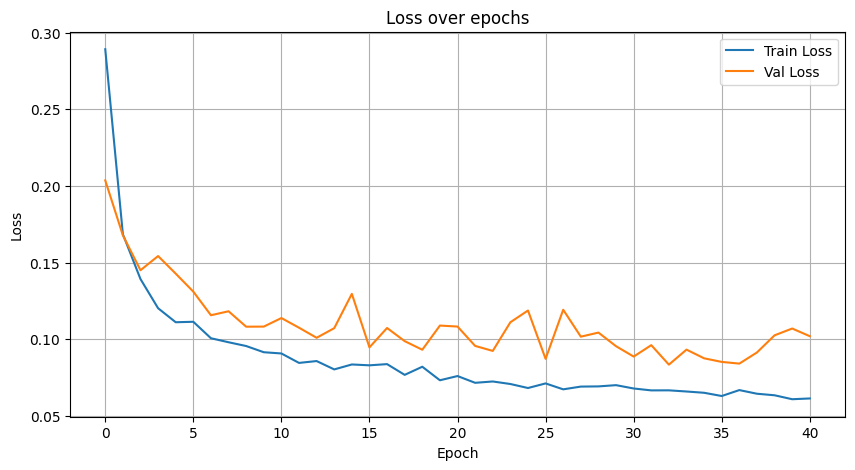

In [39]:
plt.figure(figsize=(10,5))
plt.plot(history_rgb['train_loss'], label='Train Loss')
plt.plot(history_rgb['val_loss'], label='Val Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [40]:
def evaluate_model(model, test_loader, class_names=None):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating [Test]"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # --- Metrics ---
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    print("\n--- Test Set Performance ---")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # --- Confusion Matrix ---
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (Test Set)')
    plt.show()

    return {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1}


Evaluating [Test]: 100%|██████████| 7/7 [00:57<00:00,  8.20s/it]



--- Test Set Performance ---
Accuracy : 0.9069
Precision: 0.9083
Recall   : 0.9069
F1-score : 0.9050

Classification Report:
              precision    recall  f1-score   support

      Normal       0.93      0.79      0.86       301
   Pneumonia       0.90      0.97      0.93       569

    accuracy                           0.91       870
   macro avg       0.91      0.88      0.89       870
weighted avg       0.91      0.91      0.91       870



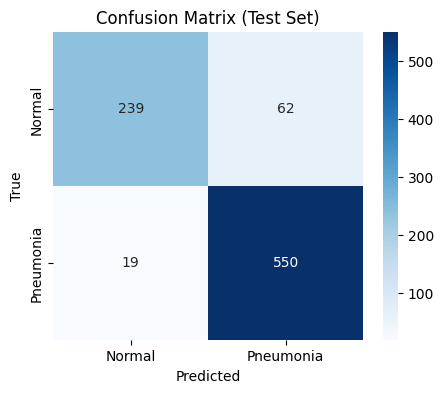

In [41]:
class_names = ["Normal", "Pneumonia"]

test_metrics = evaluate_model(model_vit_1, test_loader_rgb, class_names)

In [42]:
torch.save(model_vit_1,"ViTB16_augmented.pt")

## Non-Augmented Datasets Training

เทรนโมเดลผ่านชุดข้อมูลที่ไม่ผ่านกระบวนการ Data Augmented (Data ปกติ)

In [43]:
model_vit_2 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# Freeze feature extractor
for param in model_vit_2.parameters():
    param.requires_grad = False

num_ftrs_rgb = model_vit_2.fc.in_features
model_vit_2.fc = nn.Linear(num_ftrs_rgb, NUM_CLASSES)
model_vit_2 = model_vit_2.to(device)

optimizer_rgb = optim.Adam(model_vit_2.fc.parameters(), lr=LEARNING_RATE)

In [44]:
model_vit_2, history_rgb_2 = train_model(
    model_vit_2, 
    train_loader_rgb_noaug, 
    val_loader_rgb, 
    criterion, 
    optimizer_rgb, 
    num_epochs=NUM_EPOCHS,
    patience=PATIENCE
)


Epoch 1/100
----------------------------------------


Val 1: 100%|██████████| 7/7 [00:52<00:00,  7.48s/it]


Train Loss: 0.4201 | Acc: 0.8188
Val   Loss: 0.4095 | Acc: 0.9011

Epoch 2/100
----------------------------------------


Val 2: 100%|██████████| 7/7 [00:46<00:00,  6.66s/it]


Train Loss: 0.2555 | Acc: 0.9131
Val   Loss: 0.2729 | Acc: 0.8908

Epoch 3/100
----------------------------------------


Val 3: 100%|██████████| 7/7 [00:44<00:00,  6.36s/it]


Train Loss: 0.2083 | Acc: 0.9268
Val   Loss: 0.1977 | Acc: 0.9322

Epoch 4/100
----------------------------------------


Val 4: 100%|██████████| 7/7 [00:46<00:00,  6.61s/it]


Train Loss: 0.1862 | Acc: 0.9329
Val   Loss: 0.1792 | Acc: 0.9356

Epoch 5/100
----------------------------------------


Val 5: 100%|██████████| 7/7 [00:47<00:00,  6.77s/it]


Train Loss: 0.1691 | Acc: 0.9368
Val   Loss: 0.1684 | Acc: 0.9333

Epoch 6/100
----------------------------------------


Val 6: 100%|██████████| 7/7 [00:46<00:00,  6.61s/it]


Train Loss: 0.1526 | Acc: 0.9464
Val   Loss: 0.1607 | Acc: 0.9345

Epoch 7/100
----------------------------------------


Val 7: 100%|██████████| 7/7 [00:45<00:00,  6.47s/it]


Train Loss: 0.1465 | Acc: 0.9461
Val   Loss: 0.1548 | Acc: 0.9356

Epoch 8/100
----------------------------------------


Val 8: 100%|██████████| 7/7 [00:45<00:00,  6.43s/it]


Train Loss: 0.1386 | Acc: 0.9527
Val   Loss: 0.1516 | Acc: 0.9471

Epoch 9/100
----------------------------------------


Val 9: 100%|██████████| 7/7 [00:44<00:00,  6.36s/it]


Train Loss: 0.1308 | Acc: 0.9574
Val   Loss: 0.1438 | Acc: 0.9437

Epoch 10/100
----------------------------------------


Val 10: 100%|██████████| 7/7 [00:45<00:00,  6.51s/it]


Train Loss: 0.1241 | Acc: 0.9581
Val   Loss: 0.1400 | Acc: 0.9460

Epoch 11/100
----------------------------------------


Val 11: 100%|██████████| 7/7 [00:44<00:00,  6.35s/it]


Train Loss: 0.1207 | Acc: 0.9576
Val   Loss: 0.1449 | Acc: 0.9425

Epoch 12/100
----------------------------------------


Val 12: 100%|██████████| 7/7 [00:43<00:00,  6.26s/it]


Train Loss: 0.1173 | Acc: 0.9591
Val   Loss: 0.1424 | Acc: 0.9425

Epoch 13/100
----------------------------------------


Val 13: 100%|██████████| 7/7 [00:49<00:00,  7.11s/it]


Train Loss: 0.1137 | Acc: 0.9608
Val   Loss: 0.1331 | Acc: 0.9483

Epoch 14/100
----------------------------------------


Val 14: 100%|██████████| 7/7 [00:44<00:00,  6.34s/it]


Train Loss: 0.1057 | Acc: 0.9672
Val   Loss: 0.1311 | Acc: 0.9517

Epoch 15/100
----------------------------------------


Val 15: 100%|██████████| 7/7 [00:43<00:00,  6.25s/it]


Train Loss: 0.1026 | Acc: 0.9665
Val   Loss: 0.1361 | Acc: 0.9391

Epoch 16/100
----------------------------------------


Val 16: 100%|██████████| 7/7 [00:43<00:00,  6.27s/it]


Train Loss: 0.1006 | Acc: 0.9662
Val   Loss: 0.1287 | Acc: 0.9529

Epoch 17/100
----------------------------------------


Val 17: 100%|██████████| 7/7 [1:39:36<00:00, 853.77s/it]   


Train Loss: 0.0973 | Acc: 0.9672
Val   Loss: 0.1356 | Acc: 0.9437

Epoch 18/100
----------------------------------------


Val 18: 100%|██████████| 7/7 [00:58<00:00,  8.38s/it]


Train Loss: 0.0962 | Acc: 0.9672
Val   Loss: 0.1312 | Acc: 0.9460

Epoch 19/100
----------------------------------------


Val 19: 100%|██████████| 7/7 [00:54<00:00,  7.80s/it]


Train Loss: 0.0935 | Acc: 0.9714
Val   Loss: 0.1271 | Acc: 0.9506

Epoch 20/100
----------------------------------------


Val 20: 100%|██████████| 7/7 [00:54<00:00,  7.80s/it]


Train Loss: 0.0904 | Acc: 0.9728
Val   Loss: 0.1240 | Acc: 0.9506

Epoch 21/100
----------------------------------------


Val 21: 100%|██████████| 7/7 [00:51<00:00,  7.36s/it]


Train Loss: 0.0830 | Acc: 0.9755
Val   Loss: 0.1241 | Acc: 0.9529

Epoch 22/100
----------------------------------------


Val 22: 100%|██████████| 7/7 [00:46<00:00,  6.60s/it]


Train Loss: 0.0830 | Acc: 0.9750
Val   Loss: 0.1241 | Acc: 0.9540

Epoch 23/100
----------------------------------------


Val 23: 100%|██████████| 7/7 [00:44<00:00,  6.40s/it]


Train Loss: 0.0800 | Acc: 0.9760
Val   Loss: 0.1212 | Acc: 0.9529

Epoch 24/100
----------------------------------------


Val 24: 100%|██████████| 7/7 [00:44<00:00,  6.31s/it]


Train Loss: 0.0803 | Acc: 0.9755
Val   Loss: 0.1255 | Acc: 0.9494

Epoch 25/100
----------------------------------------


Val 25: 100%|██████████| 7/7 [00:48<00:00,  6.89s/it]


Train Loss: 0.0762 | Acc: 0.9775
Val   Loss: 0.1213 | Acc: 0.9529

Epoch 26/100
----------------------------------------


Val 26: 100%|██████████| 7/7 [00:45<00:00,  6.46s/it]


Train Loss: 0.0791 | Acc: 0.9767
Val   Loss: 0.1217 | Acc: 0.9552

Epoch 27/100
----------------------------------------


Val 27: 100%|██████████| 7/7 [00:45<00:00,  6.46s/it]


Train Loss: 0.0739 | Acc: 0.9767
Val   Loss: 0.1210 | Acc: 0.9517

Epoch 28/100
----------------------------------------


Val 28: 100%|██████████| 7/7 [00:44<00:00,  6.32s/it]


Train Loss: 0.0709 | Acc: 0.9797
Val   Loss: 0.1202 | Acc: 0.9529

Epoch 29/100
----------------------------------------


Val 29: 100%|██████████| 7/7 [00:43<00:00,  6.28s/it]


Train Loss: 0.0690 | Acc: 0.9809
Val   Loss: 0.1217 | Acc: 0.9517

Epoch 30/100
----------------------------------------


Val 30: 100%|██████████| 7/7 [00:43<00:00,  6.28s/it]


Train Loss: 0.0734 | Acc: 0.9775
Val   Loss: 0.1196 | Acc: 0.9540

Epoch 31/100
----------------------------------------


Val 31: 100%|██████████| 7/7 [00:43<00:00,  6.26s/it]


Train Loss: 0.0690 | Acc: 0.9811
Val   Loss: 0.1196 | Acc: 0.9529

Epoch 32/100
----------------------------------------


Val 32: 100%|██████████| 7/7 [00:45<00:00,  6.46s/it]


Train Loss: 0.0659 | Acc: 0.9831
Val   Loss: 0.1227 | Acc: 0.9517

Epoch 33/100
----------------------------------------


Val 33: 100%|██████████| 7/7 [00:44<00:00,  6.41s/it]


Train Loss: 0.0635 | Acc: 0.9833
Val   Loss: 0.1191 | Acc: 0.9529

Epoch 34/100
----------------------------------------


Val 34: 100%|██████████| 7/7 [00:45<00:00,  6.43s/it]

Train Loss: 0.0617 | Acc: 0.9843
Val   Loss: 0.1202 | Acc: 0.9494

Early stopping triggered after 34 epochs (no improvement in 8 epochs).

Training Complete.
Best Val Acc: 0.9552


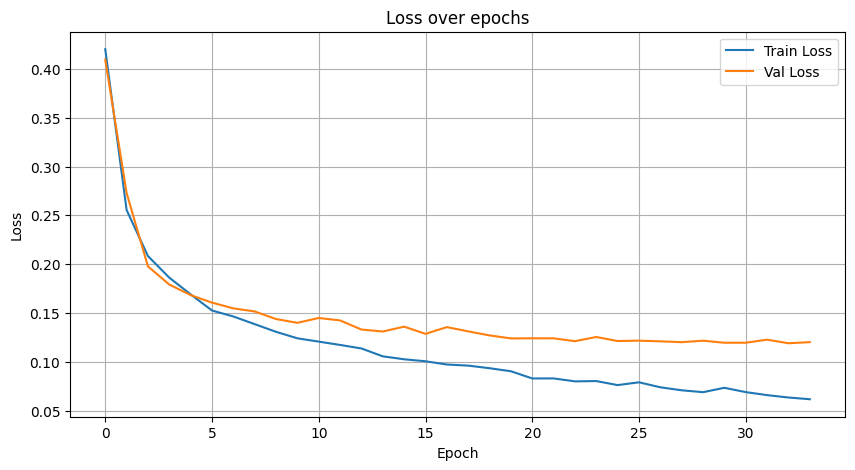

In [45]:
plt.figure(figsize=(10,5))
plt.plot(history_rgb_2['train_loss'], label='Train Loss')
plt.plot(history_rgb_2['val_loss'], label='Val Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Evaluating [Test]: 100%|██████████| 7/7 [00:46<00:00,  6.66s/it]


--- Test Set Performance ---
Accuracy : 0.8609
Precision: 0.8718
Recall   : 0.8609
F1-score : 0.8532

Classification Report:
              precision    recall  f1-score   support

      Normal       0.94      0.64      0.76       301
   Pneumonia       0.84      0.98      0.90       569

    accuracy                           0.86       870
   macro avg       0.89      0.81      0.83       870
weighted avg       0.87      0.86      0.85       870



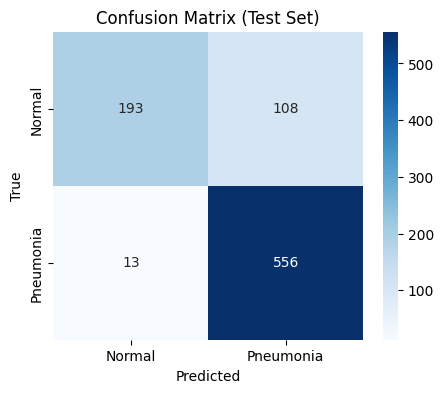

In [46]:
test_metrics_2 = evaluate_model(model_vit_2, test_loader_rgb, class_names)

In [47]:
torch.save(model_vit_2,"ViTB16_Non-augmented.pt")

# Comparison

1. **Loss Comparison** - เปรียบเทียบค่า Loss ระหว่าง 2 โมเดลที่เกิดขึ้น (Augmented vs Non-Augmented)
2. **Confusion Matrix** - เปรียบเทียบ Confusion Matrix บนชุด test ของทั้ง 2 โมเดล

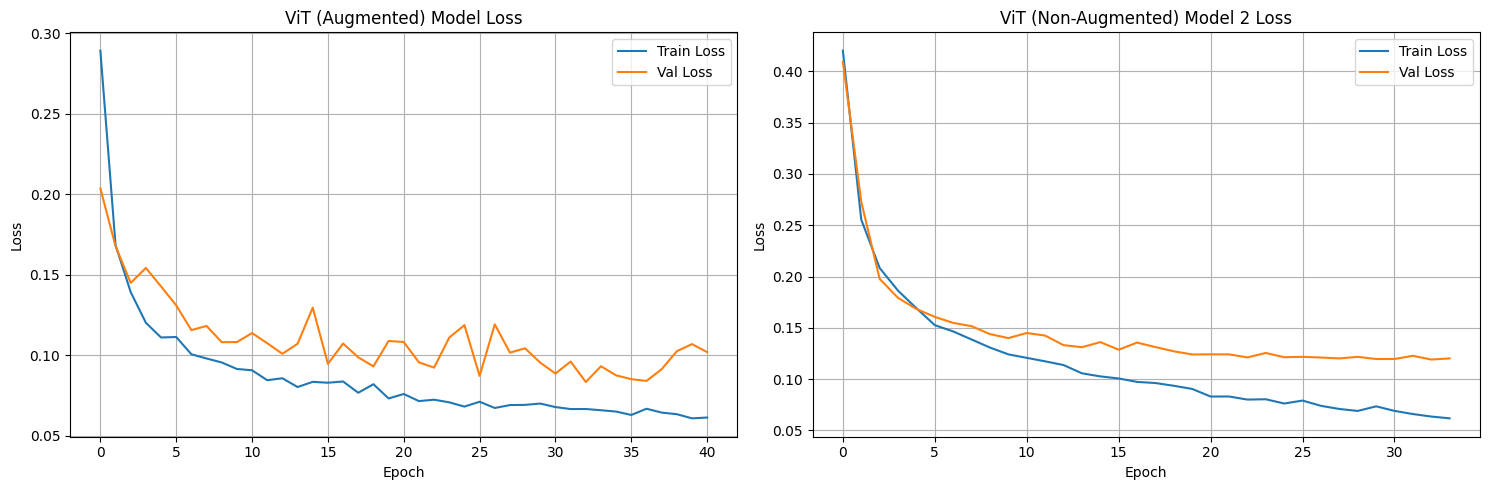

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))  

axes[0].plot(history_rgb['train_loss'], label='Train Loss')
axes[0].plot(history_rgb['val_loss'], label='Val Loss')
axes[0].set_title('ViT (Augmented) Model Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(history_rgb_2['train_loss'], label='Train Loss')
axes[1].plot(history_rgb_2['val_loss'], label='Val Loss')
axes[1].set_title('ViT (Non-Augmented) Model 2 Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()  
plt.show()


In [56]:
def plot_two_confusion_matrices(y_true1, y_pred1, y_true2, y_pred2, class_names):
    fig, axes = plt.subplots(1, 2, figsize=(12,5))

    cm1 = confusion_matrix(y_true1, y_pred1)
    sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                ax=axes[0])
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('True')
    axes[0].set_title('Model 1 (Augmented) Confusion Matrix')

    cm2 = confusion_matrix(y_true2, y_pred2)
    sns.heatmap(cm2, annot=True, fmt='d', cmap='Greens',
                xticklabels=class_names, yticklabels=class_names,
                ax=axes[1])
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('True')
    axes[1].set_title('Model 2 (Non-Augmented) Confusion Matrix')

    plt.tight_layout()
    plt.show()


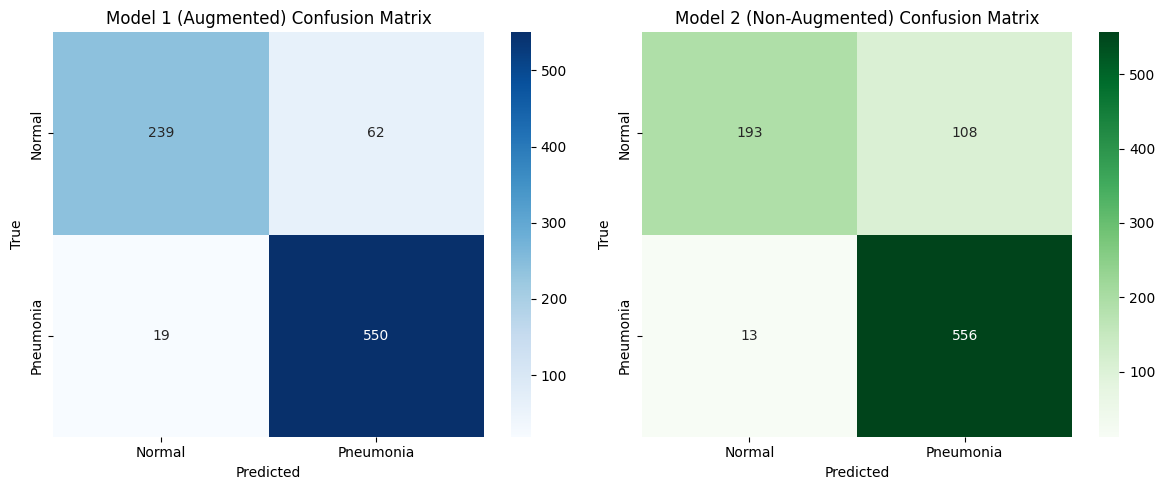

In [57]:
y_true1, y_pred1 = [], []
y_true2, y_pred2 = [], []

model_vit_1.eval()
with torch.no_grad():
    for inputs, labels in test_loader_rgb:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_vit_1(inputs)
        _, preds = torch.max(outputs, 1)
        y_true1.extend(labels.cpu().numpy())
        y_pred1.extend(preds.cpu().numpy())

model_vit_2.eval()
with torch.no_grad():
    for inputs, labels in test_loader_rgb:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_vit_2(inputs)
        _, preds = torch.max(outputs, 1)
        y_true2.extend(labels.cpu().numpy())
        y_pred2.extend(preds.cpu().numpy())

plot_two_confusion_matrices(y_true1, y_pred1, y_true2, y_pred2, class_names)

In [51]:
def evaluate_classification_report(model, test_loader, class_names=None):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating [Report Only]"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    print("\n=== Classification Report ===")
    print(classification_report(y_true, y_pred, target_names=class_names))

In [53]:
print("\n### Model 1 Classification Report (Augmented) ###")
evaluate_classification_report(model_vit_1, test_loader_rgb, class_names)

print("\n### Model 2 Classification Report (Non-Augmented) ###")
evaluate_classification_report(model_vit_2, test_loader_rgb, class_names)


### Model 1 Classification Report (Augmented) ###


Evaluating [Report Only]: 100%|██████████| 7/7 [00:53<00:00,  7.61s/it]



=== Classification Report ===
              precision    recall  f1-score   support

      Normal       0.93      0.79      0.86       301
   Pneumonia       0.90      0.97      0.93       569

    accuracy                           0.91       870
   macro avg       0.91      0.88      0.89       870
weighted avg       0.91      0.91      0.91       870


### Model 2 Classification Report (Non-Augmented) ###


Evaluating [Report Only]: 100%|██████████| 7/7 [00:43<00:00,  6.27s/it]


=== Classification Report ===
              precision    recall  f1-score   support

      Normal       0.94      0.64      0.76       301
   Pneumonia       0.84      0.98      0.90       569

    accuracy                           0.86       870
   macro avg       0.89      0.81      0.83       870
weighted avg       0.87      0.86      0.85       870



## Recap Summary Result ResNet Model

การเปรียบเทียบระหว่างโมเดลที่ผ่านการฝึกในรูปแบบ Augmented vs Non-Augmented

### Loss of Model
- **โมเดลที่ 1 (Augmented)** มีค่า loss ที่จ่ำกว่าโมเดลที่ 2 ซึ่งบ่งบอกถึงประสิทธิภาพการทำงานได้ดี แต่มีการแกว่งของ validation loss อยู่บ้าง ซึ่งเป็นพ่วงจากชุดทดสอบ Validation
- **โมเดลที่ 2 (Non-Augmented)** มีค่า loss ที่สูงกว่า แต่ความเสถียรที่เกิดขึ้นมีความเสถียรมากกว่าโมเดลที่ 1 และจากกราฟจะสามารถเทรนที่จะเกิดปัญหา Overfitting ได้มากกว่า

### Confusion Matrix
- **FP: Pneumonia but Predicted is Normal**
- **FN: Normal but Predicted is Pneumonia**

    - **โมเดลที่ 1 (Augmented)** การทำนายบน FP และ FN สามารถทำนายผิดพลาดได้ดี โดย FP = 19, FN = 62
    - **โมเดลที่ 2 (Non-Augmented)** การทำนายบน FP มีต่ำกว่าและค่า FN อยู่มาก FP = 13, FN = 108

จาก Confusion Matrix จะเห็นถึงความเสถียรของโมเดลที่ 1 ทำนายผิดพลาดได้สมดุลมากกว่า โมเดลที่ 2 ที่มีการเอนเอียงไปทาง FN มากกว่า ซึ่งในโจทย์นี้จำเป็นต้องมีการลด FN ให้ได้มากที่สุด ซึ่งโมเดลที่ 1 (Augmented) ตอบโจทย์มากกว่า

### Classification Report
โดยจุดโฟกัสหลักของโจทย์นี้จะเน้นที่ Recall, F1 และ 

- **โมเดลที่ 1 (Augmented)** 
    - Recall: ทำได้ดีมากโดยเฉพาะในคลาสของ Pneumonia และมีความแตกต่างของคลาสเล็กน้อย (ห่างกัน 0.18) ซึ่งทำได้ดี
    - F1: ค่า trade-off ระหว่าง Precision และ Recall จะสังเกตเห็นความสมดุลที่เพิ่มขึ้นมาในคลาสของ Normal
    - Accuracy: 0.91 อยู่ในเกณฑ์ที่ดี บ่งบอกประสิทธิภาพของโมเดลที่ Generalize ได้ดี และดีเยี่ยมสำหรับคลาส Pneumonia

- **โมเดลที่ 2 (Non-Augmented)**
    - Recall: มีค่า Recall ที่สูงกว่าโมเดลที่ 1 อยู่เล็กน้อย แต่ในขณะเดียวกันจะเห็นปัญหาของ class imbalanced ได้อย่างชัดเจนจาก Recall ของ Normal Class เพียง 0.64
    - F1: ค่า trade-off ระหว่าง Precision และ Recall เห็นได้ชัดว่า มีประสิทธิภาพน้อยกว่าโมเดลที่ 1 อย่างชัดเจน
    - Accuracy: 0.86 อยู่ในเกณฑ์ปานกลาง โดยยังไม่ดีเท่าโมเดลที่ 1 ในเชิงของภาพรวม

## เปรียบเทียบผล (Test Set)

| Metric | Aug | NoAug |
|--------|-----|-------|
| Accuracy | 91% | 86% |
| Pneumonia Recall | 97% | 98% |
| Pneumonia Precision | 90% | 84% |
| Pneumonia F1 | 93% | 90% |
| Normal Recall | 79% | 64% |
| Normal Precision | 93% | 94% |
| TP (Pneumonia) | 239 | 193 |
| FN (Pneumonia) | 62 | 108 |

### Result

โมเดลที่ 1 (Image Classification) ViT ที่เทรนบน Data Augmentation ทำได้มีประสิทธิภาพในชุดข้อมูลนี้

#